# Petals to the Metal - Kaggle competition

Welcome to my notebook on the Petals to the metal Kaggle Competition !

I achieved through this notebook to obtain an accuracy of 0.96214 using the ViT (Vision Transformer model) or the BEiT model with the HuggingFace "transformer" Library. I only use images of size 331x331 because of memory issues on my macbook, but feel free to test it with higher resolution images that will certainly give better results. I don't provide any way to use TPUs on Kaggle.

This notebook provides images from the competion under the "jpeg format" that are more suitable for a training using Pytorch. Some CSVs are provided listing the path for every image and its label.

Example of dataset for JPEG images : https://www.kaggle.com/datasets/msheriey/104-flowers-garden-of-eden

Enjoy exploring this notebook!

## Dataset Loading

In [23]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = "retina"

!kaggle config set -n competition -v tpu-getting-started

env: PYTORCH_ENABLE_MPS_FALLBACK=1


- competition is now set to: tpu-getting-started


In [24]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from skimage.util import random_noise

device = torch.device("mps")


class SkimageRandomNoise:
    def __init__(self, mode="gaussian", clip=True, **kwargs):
        self.mode = mode
        self.clip = clip
        self.kwargs = kwargs

    def __call__(self, image):
        image = random_noise(np.array(image), mode=self.mode, clip=self.clip, **self.kwargs)
        return Image.fromarray((image * 255).astype(np.uint8))


class FlowerDataset(Dataset):
    def __init__(self, file_csv, transform=None, train=True):
        self.file_csv = file_csv
        self.df = pd.read_csv(self.file_csv)

        if transform:
            self.transform = transform
        else:
            if train:
                self.transform = transforms.Compose(
                    [
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(20),
                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                        SkimageRandomNoise(mode="gaussian", mean=0, var=0.01),
                        transforms.ToTensor(),
                        transforms.Normalize(
                            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                        ),  # Vit Model
                        # transforms.Normalize(
                        #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                        # ),  # ImageNet
                        # transforms.Normalize(mean=[0.4492, 0.4156, 0.3031], std=[0.2439, 0.2111, 0.2211]), # FlowerPetal
                    ]
                )
            else:
                self.transform = transforms.Compose(
                    [
                        transforms.ToTensor(),
                        transforms.Normalize(
                            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                        ),  # Vit Model
                        # transforms.Normalize(
                        #     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                        # ),  # ImageNet
                        # transforms.Normalize(
                        #     mean=[0.4492, 0.4156, 0.3031], std=[0.2439, 0.2111, 0.2211]
                        # ),  # FlowerPetal
                    ]
                )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, imgpath, info = self.df.iloc[idx]
        image = Image.open(imgpath)

        if self.transform:
            image = self.transform(image)

        return image, info

## Dataset Exploration

In [25]:
LABELS = [
    "pink primrose",
    "hard-leaved pocket orchid",
    "canterbury bells",
    "sweet pea",
    "wild geranium",
    "tiger lily",
    "moon orchid",
    "bird of paradise",
    "monkshood",
    "globe thistle",  # 00 - 09
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "giant white arum lily",  # 10 - 19
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "sweet william",  # 20 - 29
    "carnation",
    "garden phlox",
    "love in the mist",
    "cosmos",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "lenten rose",  # 30 - 39
    "barberton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "daisy",
    "common dandelion",  # 40 - 49
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "lilac hibiscus",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "pink-yellow dahlia",  # 50 - 59
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "iris",
    "windflower",
    "tree poppy",  # 60 - 69
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "anthurium",  # 70 - 79
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen ",
    "watercress",
    "canna lily",  # 80 - 89
    "hippeastrum ",
    "bee balm",
    "pink quill",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "blanket flower",  # 90 - 99
    "trumpet creeper",
    "blackberry lily",
    "common tulip",
    "wild rose",
]  # 100 - 102

In [26]:
# train_dataset = FlowerDataset("train-331x331.csv", transform=transforms.ToTensor()) # ViT
train_dataset = FlowerDataset("train-224x224.csv", transform=transforms.ToTensor())  # BEiT
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

class_images = {}
class_distribution = {}

for image_batch, info_batch in train_dataloader:
    for index, info in enumerate(info_batch):
        if int(info) not in class_images:
            class_images[int(info)] = image_batch[index]
            class_distribution[int(info)] = 1
        else:
            class_distribution[int(info)] += 1

df_distribution = (
    pd.DataFrame.from_dict(class_distribution, orient="index")
    .sort_index()
    .rename(columns={0: "Count"})
    .reset_index(names="Index")
)

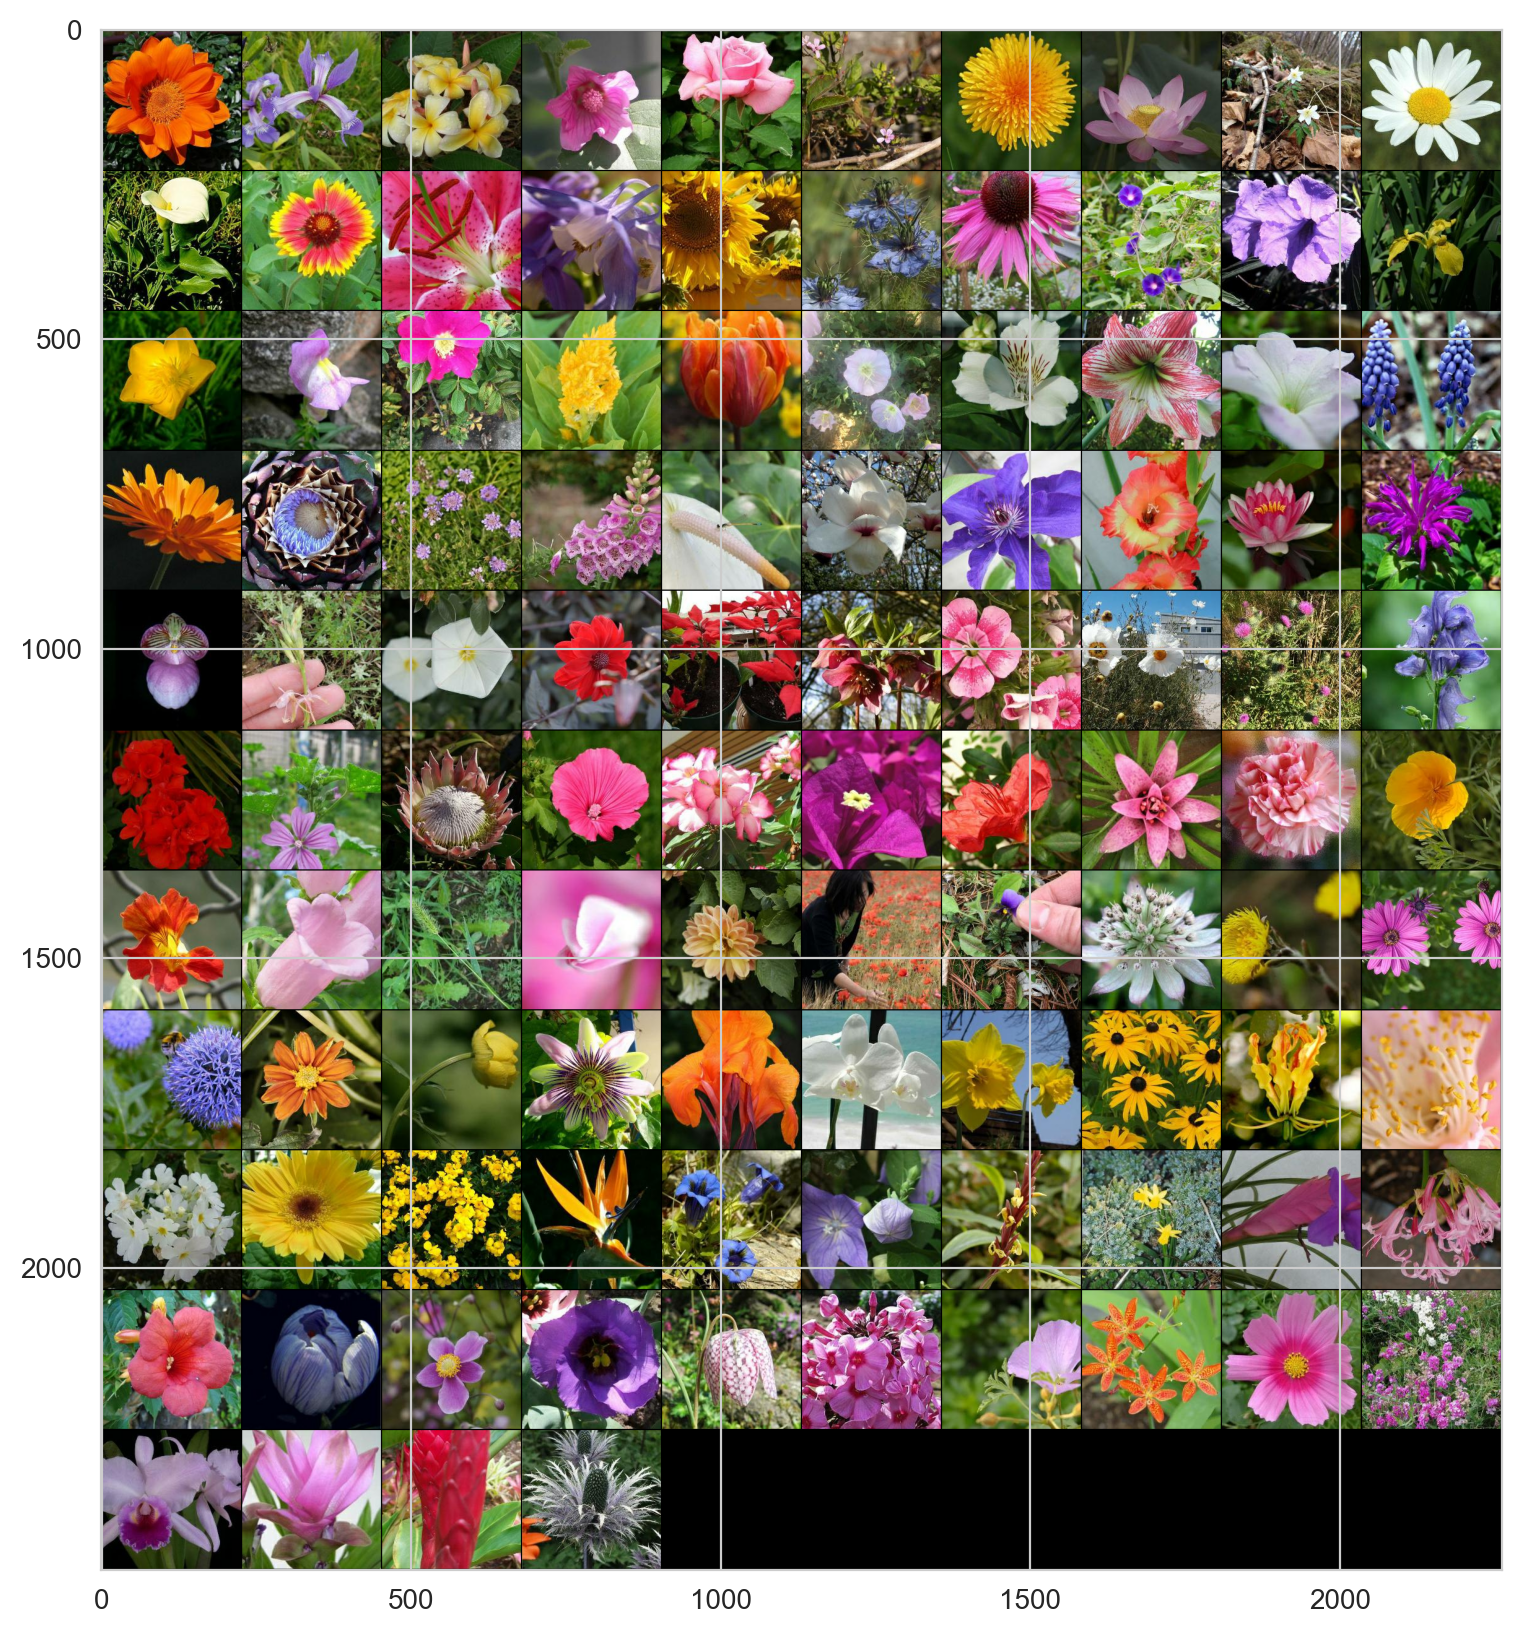

In [27]:
images = torch.stack(list(class_images.values()))

# Batch of images with shape [B, C, H, W] converted to [H', W', C]
plt.figure(figsize=(10, 10))
grid_img = torchvision.utils.make_grid(images, nrow=10).permute(1, 2, 0).numpy()
plt.imshow(grid_img)
plt.show()

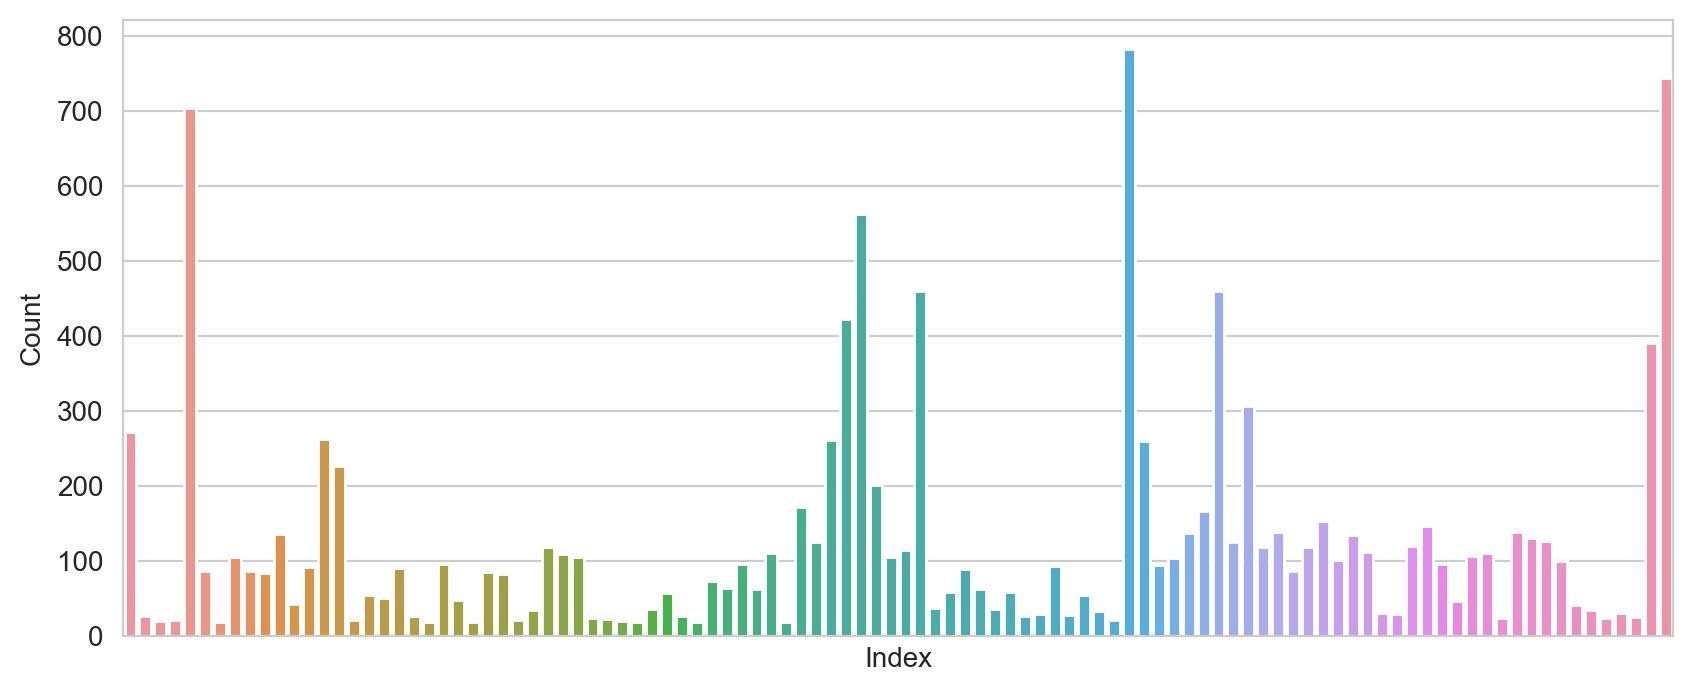

In [28]:
plt.figure(figsize=(10, 4))
sns.barplot(df_distribution, x="Index", y="Count")
plt.xticks([])
plt.show()

- `len(train)` : 12753
- `len(val)` : 3712
- `len(test)` : 7382

## Training

### Model and parameters of the training (fine-tuning)

In [29]:
# num_epochs = 20 # ViT
num_epochs = 25  # BEiT
batch_size = 32
step_epoch = -(12753 // -batch_size)  # roof
N_steps = num_epochs * step_epoch
warmup_iterations = N_steps // 10
# T_max_cosines = N_steps // 0.5
T_max_cosines = N_steps // 0.7

In [30]:
from transformers import AutoModelForImageClassification

label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for i, label in enumerate(LABELS)}

model = AutoModelForImageClassification.from_pretrained(
    # "google/vit-base-patch16-224",
    "microsoft/beit-base-patch16-224-pt22k-ft22k",
    num_labels=len(LABELS),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR

# optimizer = Adam(
#     model.parameters(),
#     lr=0.0001,
#     betas=(0.9, 0.999),
#     weight_decay=0.1,
# )

optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

lr_scheduler_warmup = LinearLR(
    optimizer, start_factor=0.3, end_factor=1.0, total_iters=warmup_iterations
)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=T_max_cosines)

# train_dataset = FlowerDataset("train-331x331.csv", train=True) # ViT
# val_dataset = FlowerDataset("val-331x331.csv", train=False) # ViT

train_dataset = FlowerDataset("train-224x224.csv", train=True)
val_dataset = FlowerDataset("val-224x224.csv", train=False)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([104, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([104]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
model.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_list = []
step_list = []
step = 0

for epoch in tqdm(range(num_epochs)):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # outputs = model(images).logits
        outputs = model(images, interpolate_pos_encoding=True).logits
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        optimizer.step()

        # LR Scheduler
        if step > warmup_iterations:
            lr_scheduler.step()
            current_lr = lr_scheduler.get_last_lr()[0]
        else:
            lr_scheduler_warmup.step()
            current_lr = lr_scheduler_warmup.get_last_lr()[0]
        lr_list.append(current_lr)
        step_list.append(step / step_epoch)
        step += 1

        # Update metrics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = (correct_predictions.float() / len(train_dataloader.dataset)).item()
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images).logits
            # loss = outputs.loss
            loss = criterion(outputs, labels)

            # Update metrics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_dataloader.dataset)
    epoch_acc = (correct_predictions.float() / len(val_dataloader.dataset)).item()
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)
    print(f"Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_acc:.4f}")

### Save model

In [32]:
import os
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
# dir_name = f"models/vit_{dt_string}"
dir_name = f"models/beit_{dt_string}"
os.makedirs(dir_name, exist_ok=True)
model.save_pretrained(dir_name)

### Training Curves

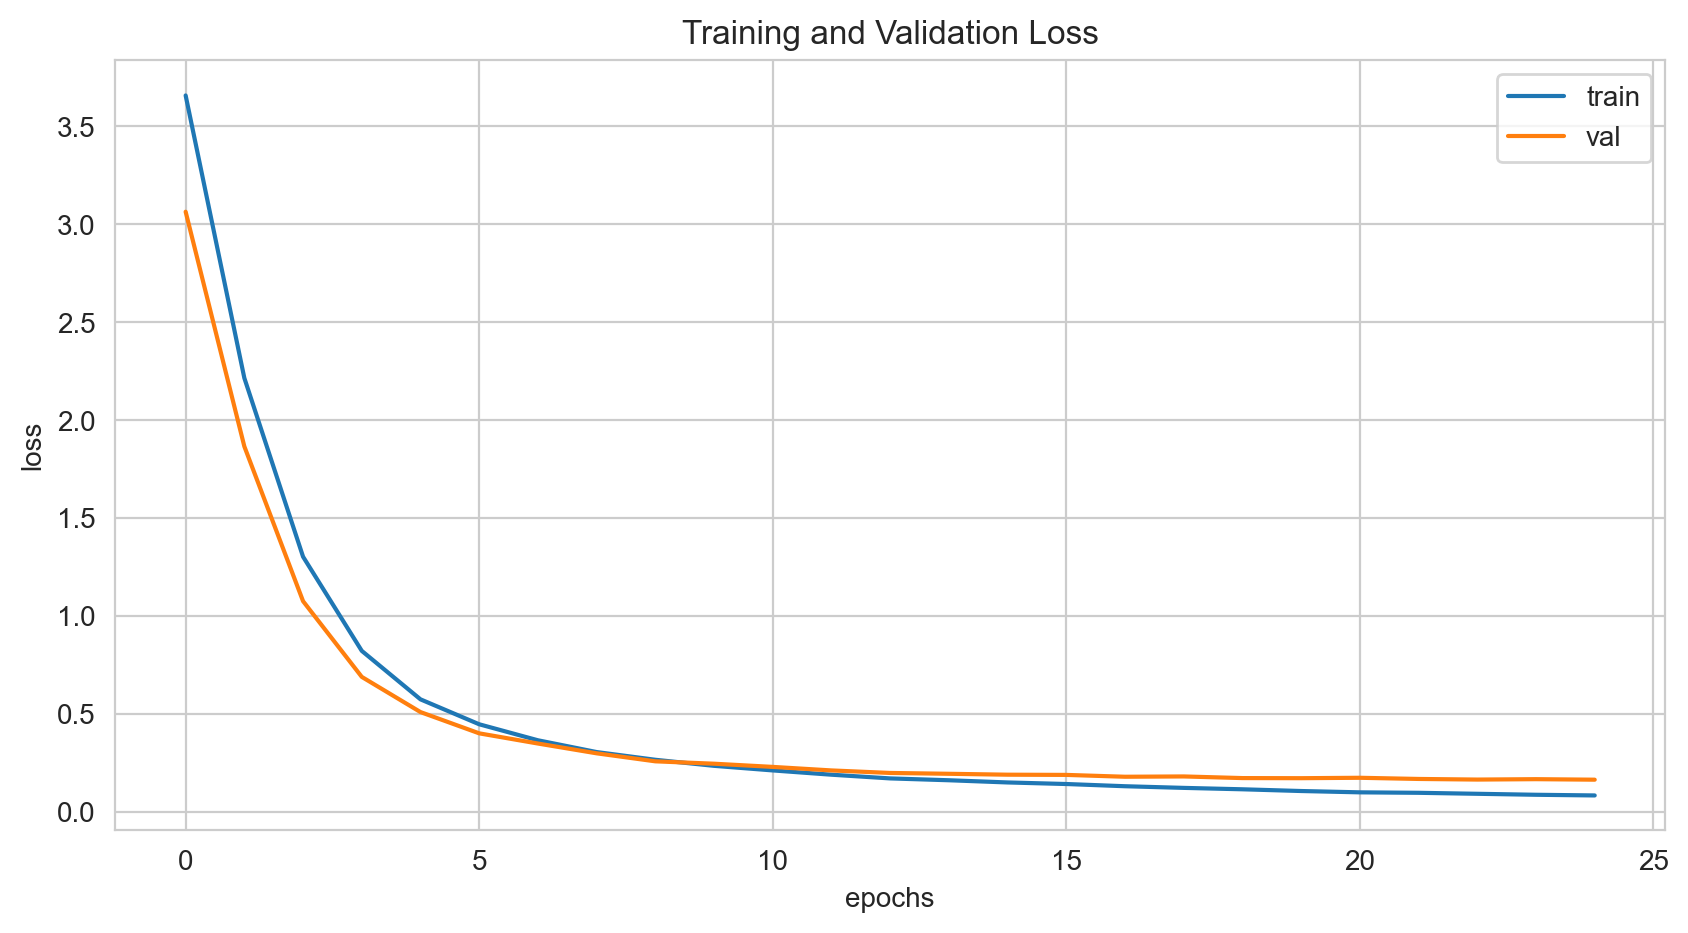

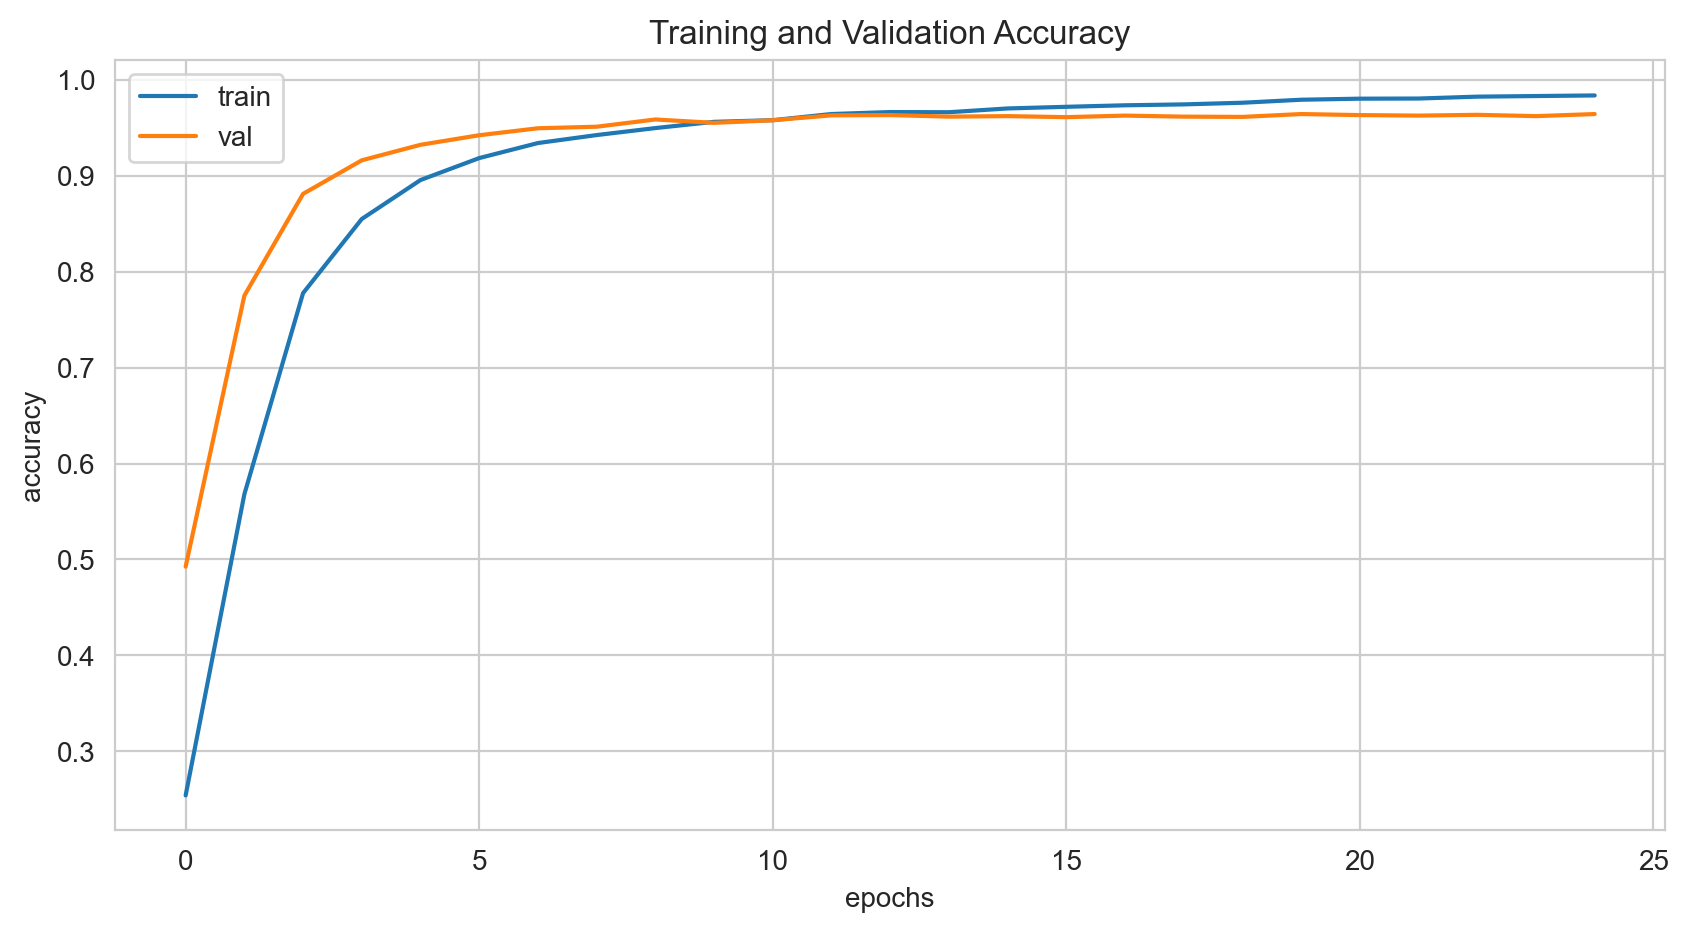

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


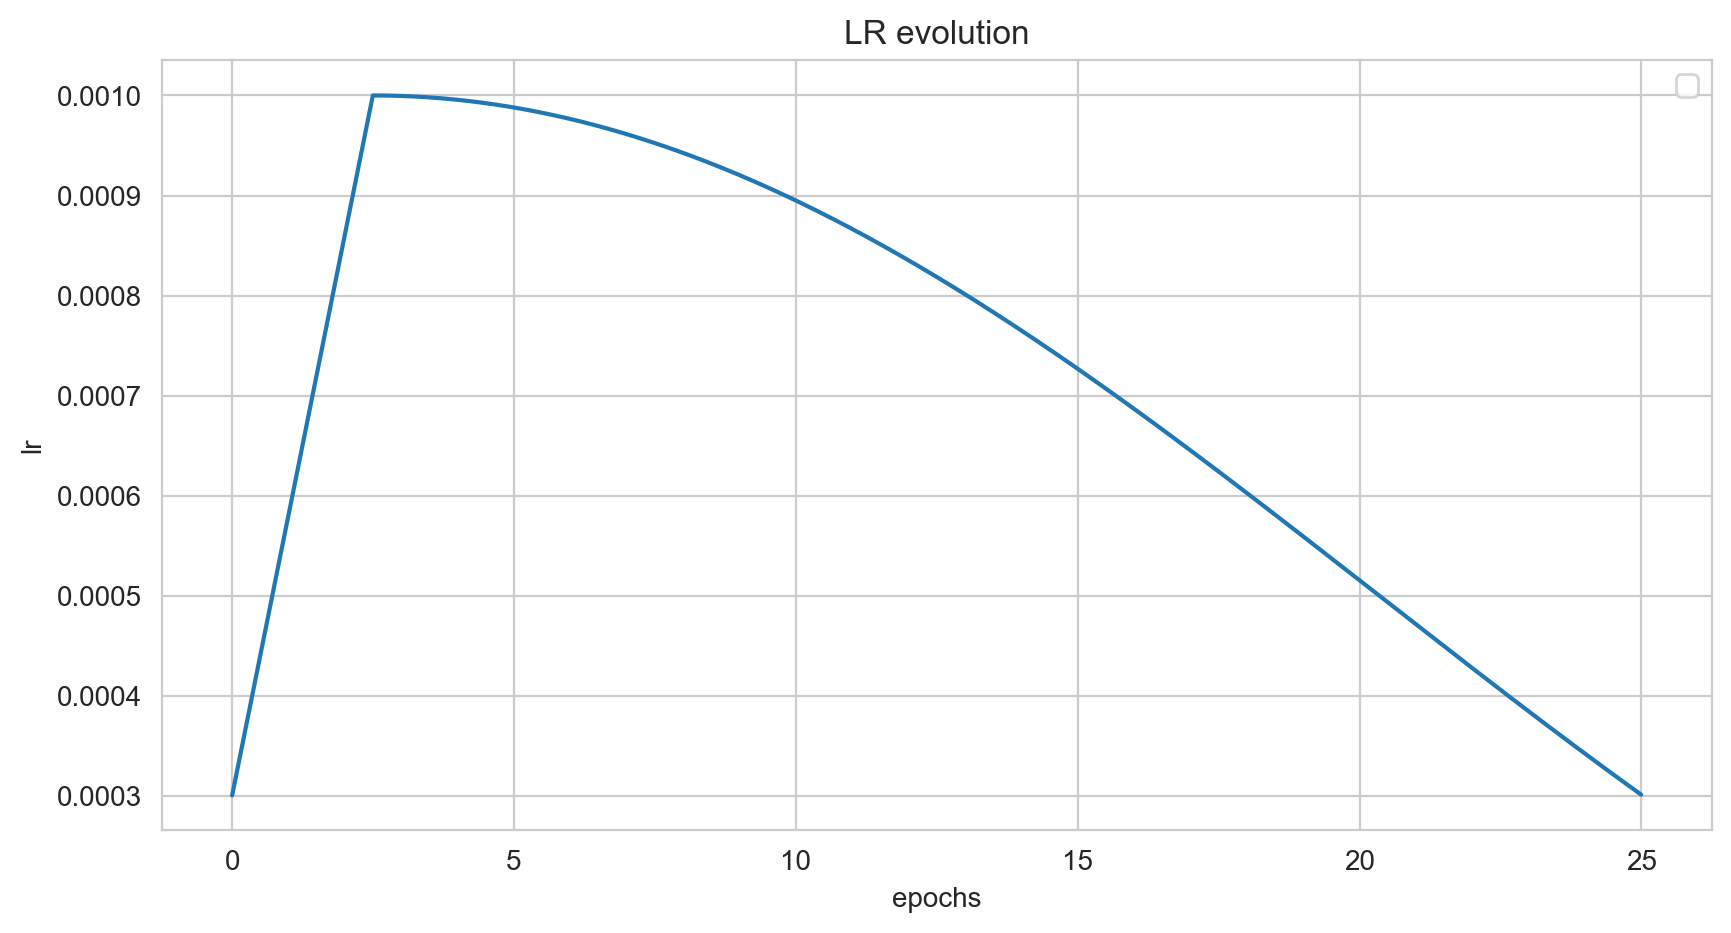

In [33]:
sns.set_style("whitegrid")  # you can choose other styles like 'darkgrid', 'dark', 'white', 'ticks'

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="train")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig(f"{dir_name}/loss.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
sns.lineplot(x=range(len(train_accuracies)), y=train_accuracies, label="train")
sns.lineplot(x=range(len(val_accuracies)), y=val_accuracies, label="val")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(f"{dir_name}/acc.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.title("LR evolution")
sns.lineplot(x=step_list, y=lr_list)
plt.xlabel("epochs")
plt.ylabel("lr")
plt.savefig(f"{dir_name}/lr.png")
plt.show()

### Test predictions

In [34]:
# test_dataset = FlowerDataset("test-331x331.csv", train=False) #ViT
test_dataset = FlowerDataset("test-224x224.csv", train=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test loop
model.eval()

# Initialize lists to store ids and labels
test_ids = []
test_preds = []

with torch.no_grad():
    for images, ids in tqdm(test_dataloader):
        images = images.to(device)

        # Forward pass
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        # Convert tensor to list and extend the lists
        test_ids.extend(ids)
        test_preds.extend(preds.cpu().numpy())

# Create DataFrame
df_submission = pd.DataFrame({"id": test_ids, "label": test_preds})
print(df_submission)
df_submission.to_csv(f"{dir_name}/submission.csv", index=False)

  0%|          | 0/231 [00:00<?, ?it/s]

             id  label
0     59d1b6146     70
1     48c96bd6b     73
2     7b437ba4e      9
3     1b7aef8e8     79
4     d6143b4d4      4
...         ...    ...
7377  2a608c0db    103
7378  d82a21bbd     93
7379  f9c931893     53
7380  18c7b92b8     41
7381  523df966b    102

[7382 rows x 2 columns]


### Submit on Kaggle

In [35]:
# !kaggle competitions submit -f models/vit_2023_07_28_02_00_25/submission.csv -m ""

In [37]:
!kaggle competitions submissions


Using competition: tpu-getting-started
fileName            date                 description                              status    publicScore  privateScore  
------------------  -------------------  ---------------------------------------  --------  -----------  ------------  
notebook1b6c8a6ff5  2023-08-01 16:01:48  Notebook notebook1b6c8a6ff5 | Version 4  complete  0.95591                    
notebook1b6c8a6ff5  2023-07-30 15:17:48  Notebook notebook1b6c8a6ff5 | Version 3  complete  0.96214                    
notebook1b6c8a6ff5  2023-07-28 07:05:36  From my own Notebook                     complete  0.92243                    
notebook1b6c8a6ff5  2023-07-28 07:05:07  Notebook notebook1b6c8a6ff5 | Version 2  complete  0.92243                    
